In [1]:
required_packages <- c("ggplot2", "stringr", "scales", "tibble", "dplyr", "emmeans", "car", "nls2","paletteer","broom")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package, dependencies = TRUE)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(required_packages, install_and_load))


Loading required package: ggplot2

Loading required package: stringr

Loading required package: scales

Loading required package: tibble

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: emmeans

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'

Loading required package: car

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Loading required package: nls2

Loading required package: proto

Loading required package: paletteer

Loading required package: broom



In [2]:
# 设置工作目录（请替换为您的实际目录）
setwd("output_files")

# 读取csv文件
data <- read.csv("api_responses.csv", stringsAsFactors = FALSE)

# 选择需要的列
data <- data[c("model_alias", "temperature", "top_p", "frequency_penalty", "presence_penalty", "response_text", "task_type","category")]

# 创建结果数据框
results <- data.frame(
  ModelAliasAlias = character(),
  Type = character(),
  Temperature = numeric(),
  TopP = numeric(),
  FrequencyPenalty = numeric(),
  PresencePenalty = numeric(),
  Rank = numeric(),
  Frequency = numeric(),
  WordLength = numeric(),
  Category = character(),
  stringsAsFactors = FALSE
)

# 计算每个组内response_text的词频
for (i in 1:nrow(data)) {
  # 提取当前行的数据
  curr_row <- data[i, ]

  # 计算词频
  text <- tolower(curr_row$response_text)
  text <- unlist(strsplit(text, "\\W+"))
  text <- text[text != ""]
  freq <- sort(table(text), decreasing = TRUE)

  # 创建数据框
  temp_df <- data.frame(
    ModelAliasAliasAliasAlias = curr_row$model_alias,
    Type = curr_row$task_type,
    Temperature = curr_row$temperature,
    TopP = curr_row$top_p,
    FrequencyPenalty = curr_row$frequency_penalty,
    PresencePenalty = curr_row$presence_penalty,
    Rank = seq_along(freq),
    Frequency = as.numeric(freq),
    WordLength = nchar(names(freq)),
    Category = curr_row$category,
    stringsAsFactors = FALSE
  )

  # 添加到结果数据框
  results <- rbind(results, temp_df)
}

# 打印结果
print(results)

        ModelAlias             Type Temperature TopP FrequencyPenalty
1    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
2    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
3    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
4    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
5    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
6    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
7    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
8    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
9    GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
10   GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
11   GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
12   GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
13   GPT 3.5 Turbo Creative writing         0.5  0.9              0.2
14   GPT 3.5 Turbo C

In [4]:
# 计算每个Type、ModelAlias和WordLength的平均频率
avg_freq <- results %>%
  group_by(Type, ModelAlias, WordLength) %>%
  summarise(AvgFrequency = mean(Frequency, na.rm = TRUE)) %>%
  ungroup()

# 获取唯一的Type值
types <- unique(avg_freq$Type)

# 为每个Type创建一个图
for (type in types) {
  # 筛选当前Type的数据
  type_data <- avg_freq %>% filter(Type == type)

  # 获取当前Type的唯一Model值
  models <- unique(type_data$ModelAlias)

  # 使用paletteer选择配色方案
  colors <- paletteer_d("ggsci::default_uchicago", n = length(models))

  # 进行双因素方差分析
  model <- lm(AvgFrequency ~ ModelAlias * WordLength, data = type_data)
  anova_result <- car::Anova(model, type = 3)

  # 提取WordLength的p值
  wordlength_p <- anova_result["WordLength", "Pr(>F)"]

  # 确定WordLength的显著性
  wordlength_sig <- case_when(
    wordlength_p < 0.001 ~ "***",
    wordlength_p < 0.01 ~ "**",
    wordlength_p < 0.05 ~ "*",
    TRUE ~ "n.s."
  )

  # 创建折线图
  p <- ggplot(type_data, aes(x = WordLength, y = AvgFrequency, color = Model)) +
    geom_line() +
    geom_point() +
    scale_color_manual(values = colors) +
    labs(title = paste("Word Length Distribution -", type),
         subtitle = paste("WordLength significance:", wordlength_sig),
         x = "Word Length",
         y = "Average Frequency") +
    theme_minimal() +
    theme(legend.position = "bottom")

  # 显示图形
  print(p)

  # 保存图片到临时文件并在Jupyter中显示
  temp_file <- tempfile(fileext = ".png")
  ggsave(temp_file, p, width = 12, height = 8)
  #IRdisplay::display_png(file = temp_file)

  # 打印ANOVA结果
  print(anova_result)
}


# 计算每个文件的平均词长
avg_word_length <- aggregate(WordLength ~ File + Type + ModelAlias, data = results, FUN = mean)
print(avg_word_length)

# 按Type和Model分组的词频统计
word_freq_by_group <- aggregate(Frequency ~ Type + ModelAlias, data = results, FUN = sum)
print(word_freq_by_group)

`summarise()` has grouped output by 'Type', 'ModelAlias'. You can override
using the `.groups` argument.


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


Anova Table (Type III tests)

Response: AvgFrequency
                 Sum Sq Df F value    Pr(>F)    
(Intercept)     1046.31  1 28.9411 3.507e-06 ***
Type               8.14  2  0.1126 0.8937751    
WordLength       590.42  1 16.3312 0.0002348 ***
Type:WordLength   29.96  2  0.4143 0.6636177    
Residuals       1446.12 40                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


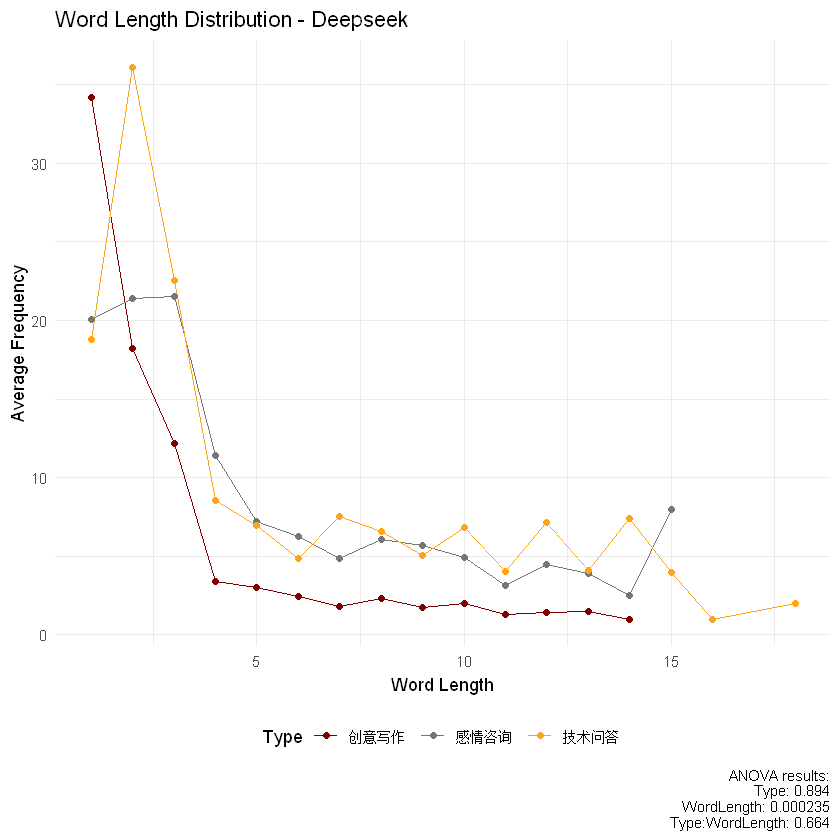

Anova Table (Type III tests)

Response: AvgFrequency
                 Sum Sq Df F value    Pr(>F)    
(Intercept)     1151.49  1 32.0668 1.523e-06 ***
Type              76.65  2  1.0672  0.353786    
WordLength       623.34  1 17.3589  0.000166 ***
Type:WordLength   99.38  2  1.3837  0.262675    
Residuals       1400.46 39                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


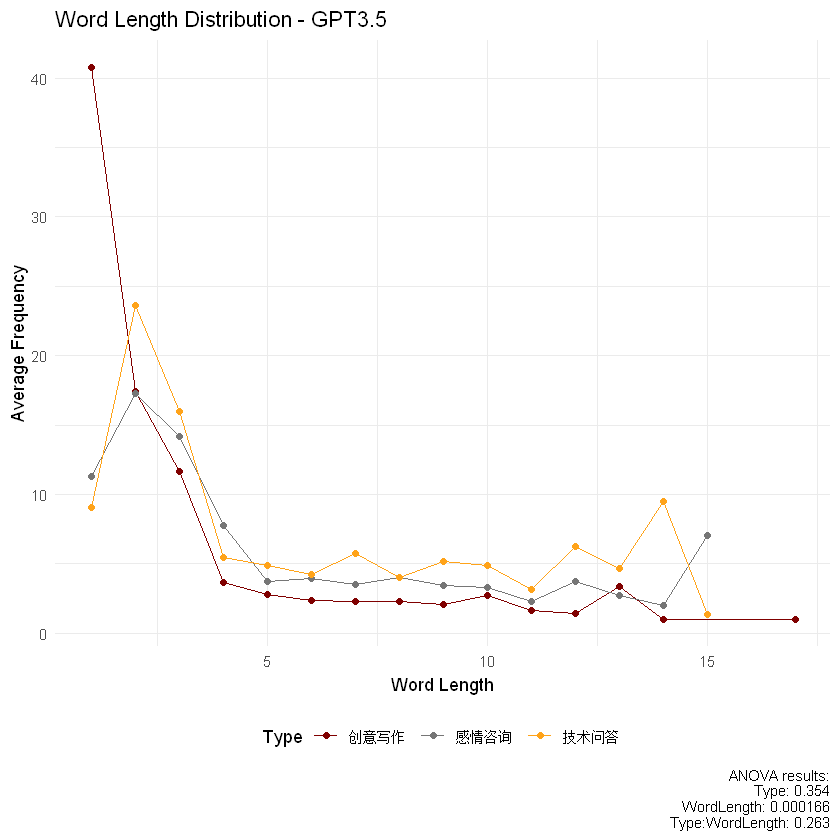

Anova Table (Type III tests)

Response: AvgFrequency
                 Sum Sq Df F value    Pr(>F)    
(Intercept)     1226.69  1 39.9058 1.693e-07 ***
Type              36.25  2  0.5896    0.5593    
WordLength       686.11  1 22.3202 2.837e-05 ***
Type:WordLength   91.27  2  1.4845    0.2388    
Residuals       1229.58 40                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


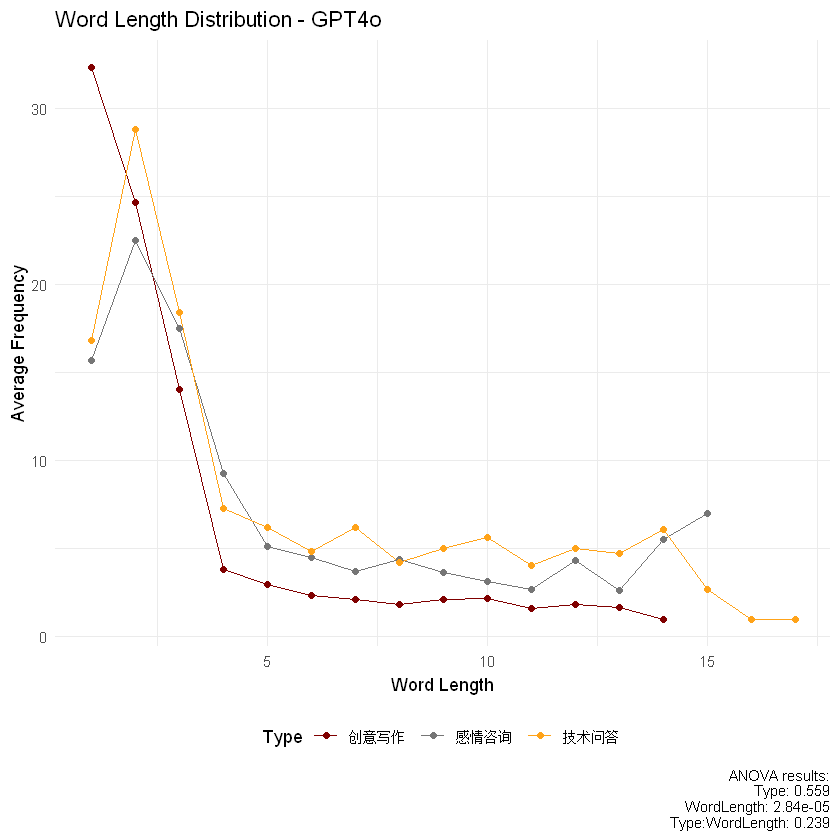

Anova Table (Type III tests)

Response: AvgFrequency
                 Sum Sq Df F value    Pr(>F)    
(Intercept)     1766.65  1 51.5651 1.402e-08 ***
Type             126.78  2  1.8503   0.17108    
WordLength       915.94  1 26.7345 7.784e-06 ***
Type:WordLength  213.89  2  3.1215   0.05557 .  
Residuals       1301.90 38                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


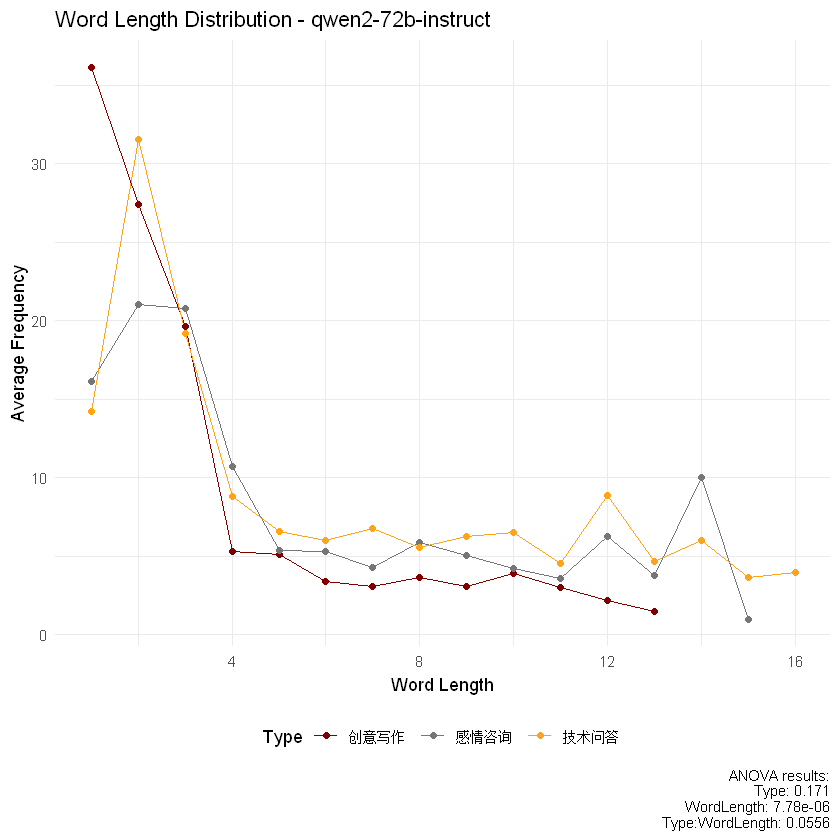

Anova Table (Type III tests)

Response: AvgFrequency
                 Sum Sq Df F value    Pr(>F)    
(Intercept)     1852.98  1 43.7546 8.206e-08 ***
Type              26.11  2  0.3083  0.736544    
WordLength       741.35  1 17.5055  0.000163 ***
Type:WordLength   95.48  2  1.1273  0.334499    
Residuals       1609.28 38                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


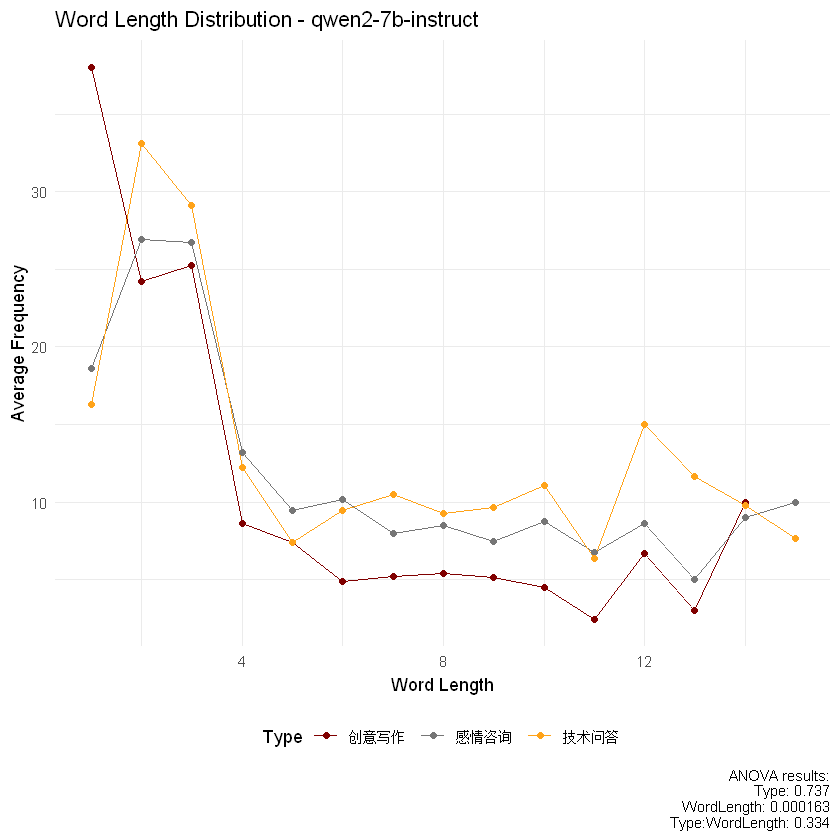

In [4]:
# 获取唯一的Model值
models <- unique(avg_freq$Model)

# 为每个Model创建一个图
for (model in models) {
  # 筛选当前Model的数据
  model_data <- avg_freq %>% filter(Model == model)

  # 获取当前Model的唯一Type值
  types <- unique(model_data$Type)

  # 使用paletteer选择配色方案
  colors <- paletteer_d("ggsci::default_uchicago", n = length(types))

  # 进行双因素方差分析
  anova_model <- lm(AvgFrequency ~ Type * WordLength, data = model_data)
  anova_result <- car::Anova(anova_model, type = 3)

  # 进行事后检验
  emm <- emmeans(anova_model, ~ Type | WordLength)
  pairwise_comparisons <- pairs(emm)

  # 提取显著性信息
  significance <- try({
    data.frame(
      WordLength = pairwise_comparisons@grid$WordLength,
      p.value = pairwise_comparisons@.Data$p.value
    ) %>%
    group_by(WordLength) %>%
    summarise(
      significance = case_when(
        min(p.value, na.rm = TRUE) < 0.001 ~ "***",
        min(p.value, na.rm = TRUE) < 0.01 ~ "**",
        min(p.value, na.rm = TRUE) < 0.05 ~ "*",
        TRUE ~ ""
      )
    )
  }, silent = TRUE)

  # 创建折线图
  p <- ggplot(model_data, aes(x = WordLength, y = AvgFrequency, color = Type)) +
    geom_line() +
    geom_point() +
    scale_color_manual(values = colors) +
    labs(title = paste("Word Length Distribution -", model),
         x = "Word Length",
         y = "Average Frequency") +
    theme_minimal() +
    theme(legend.position = "bottom")

  # 如果有显著性数据，添加到图上
  if (!inherits(significance, "try-error") && nrow(significance) > 0) {
    p <- p + geom_text(data = significance, aes(x = WordLength, y = Inf, label = significance),
                       vjust = -0.5, color = "black", size = 4)
  }

  # 添加ANOVA结果摘要
  anova_summary <- paste(
    "ANOVA results:",
    paste("Type:", format.pval(anova_result["Type", "Pr(>F)"], digits = 3)),
    paste("WordLength:", format.pval(anova_result["WordLength", "Pr(>F)"], digits = 3)),
    paste("Type:WordLength:", format.pval(anova_result["Type:WordLength", "Pr(>F)"], digits = 3)),
    sep = "\n"
  )
  p <- p + labs(caption = anova_summary)

  # 显示图形
  print(p)

  # 保存图片到临时文件并在Jupyter中显示
  temp_file <- tempfile(fileext = ".png")
  ggsave(temp_file, p, width = 12, height = 8)
  #IRdisplay::display_png(file = temp_file)

  # 打印完整ANOVA结果
  print(anova_result)
}


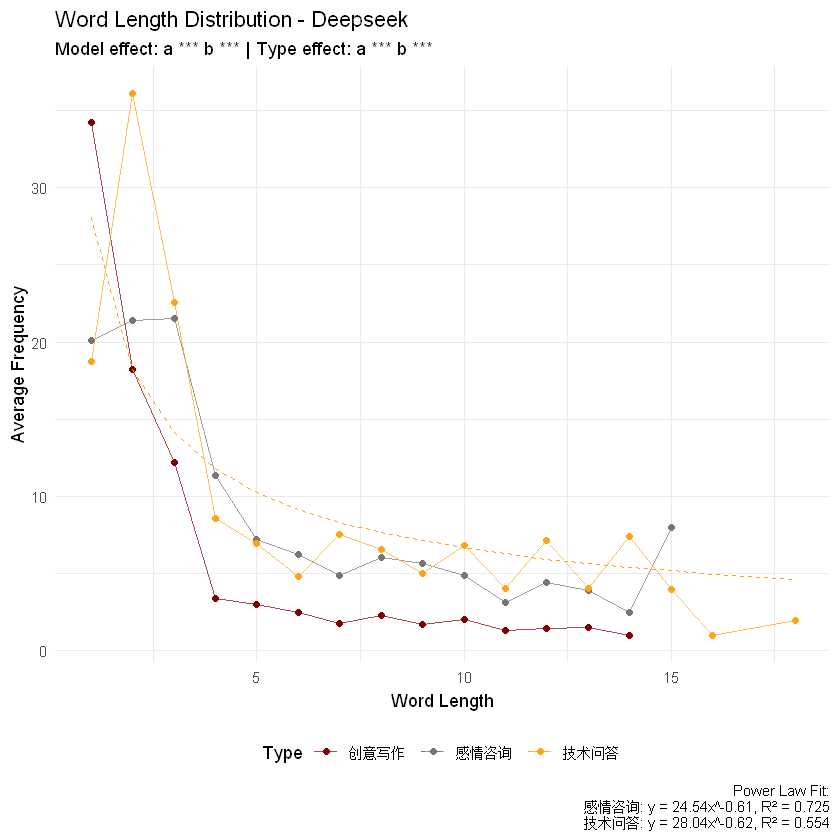

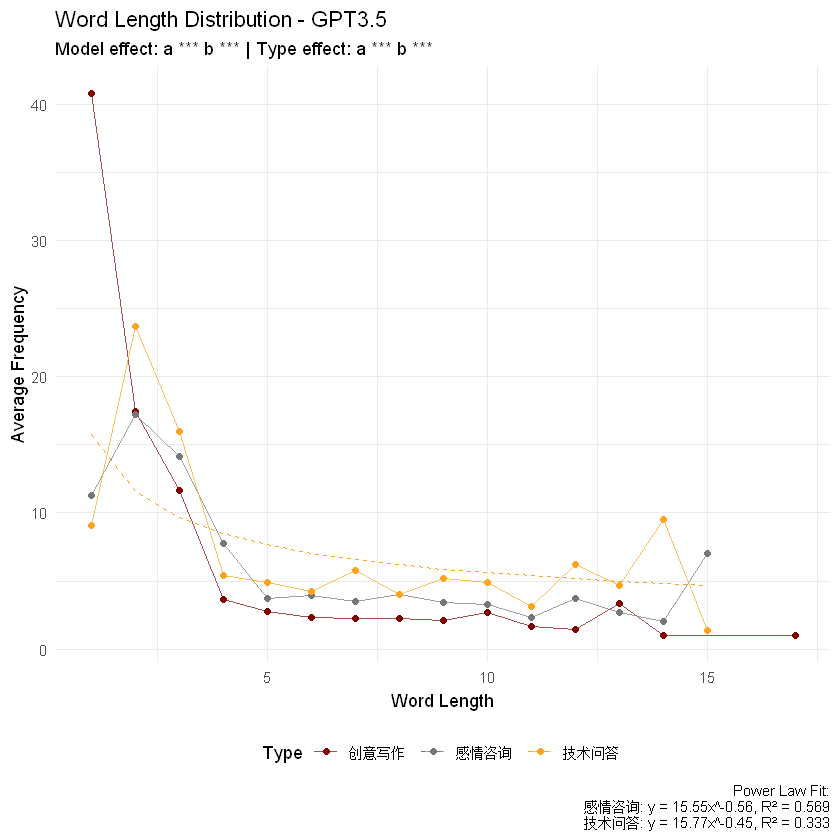

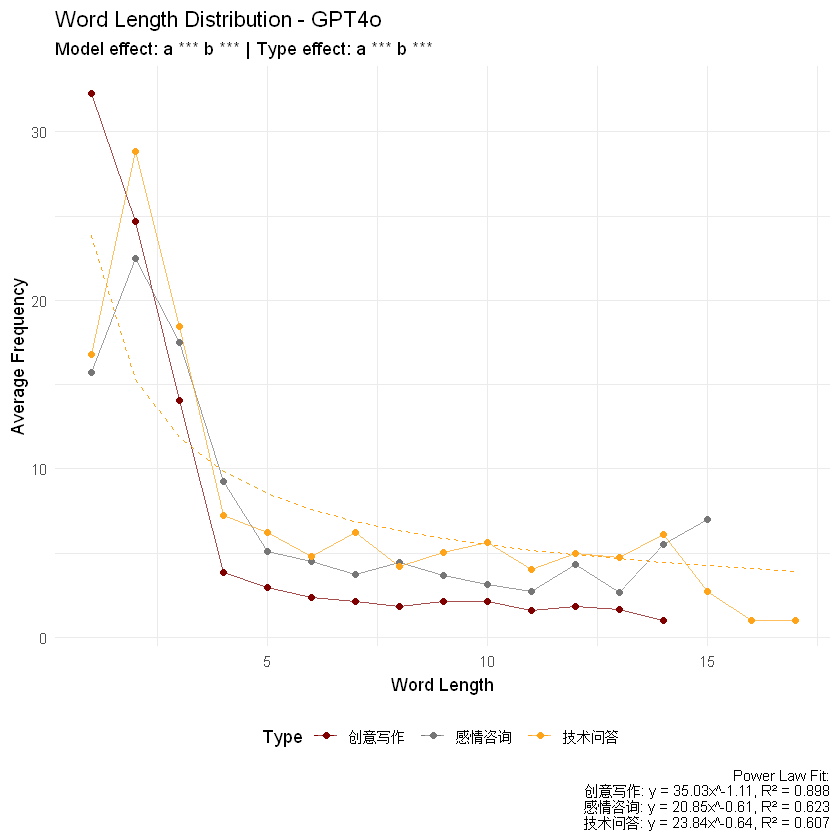

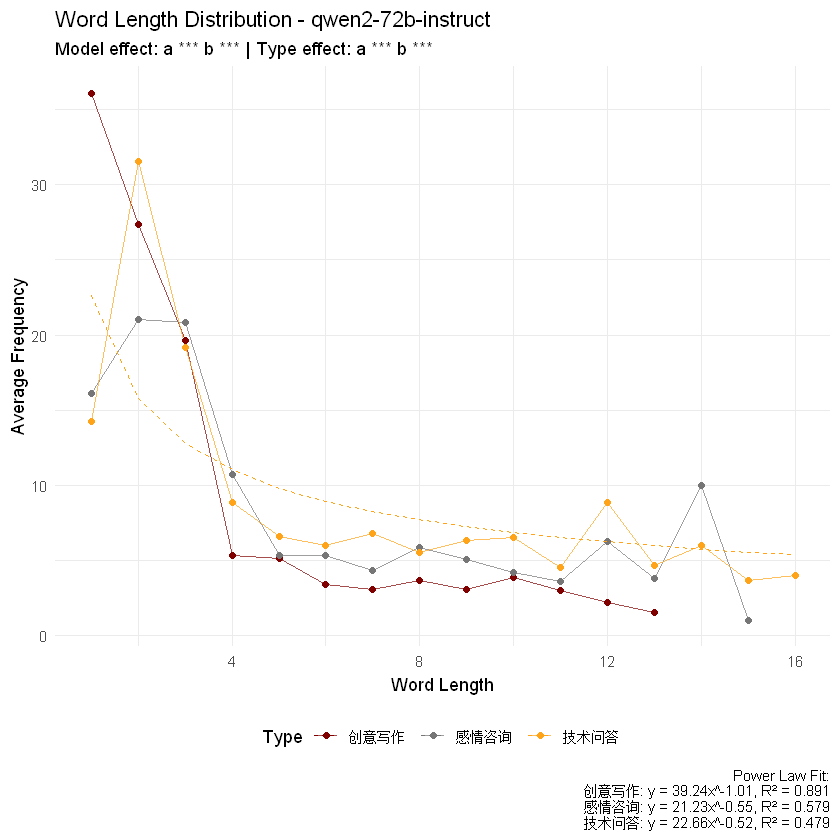

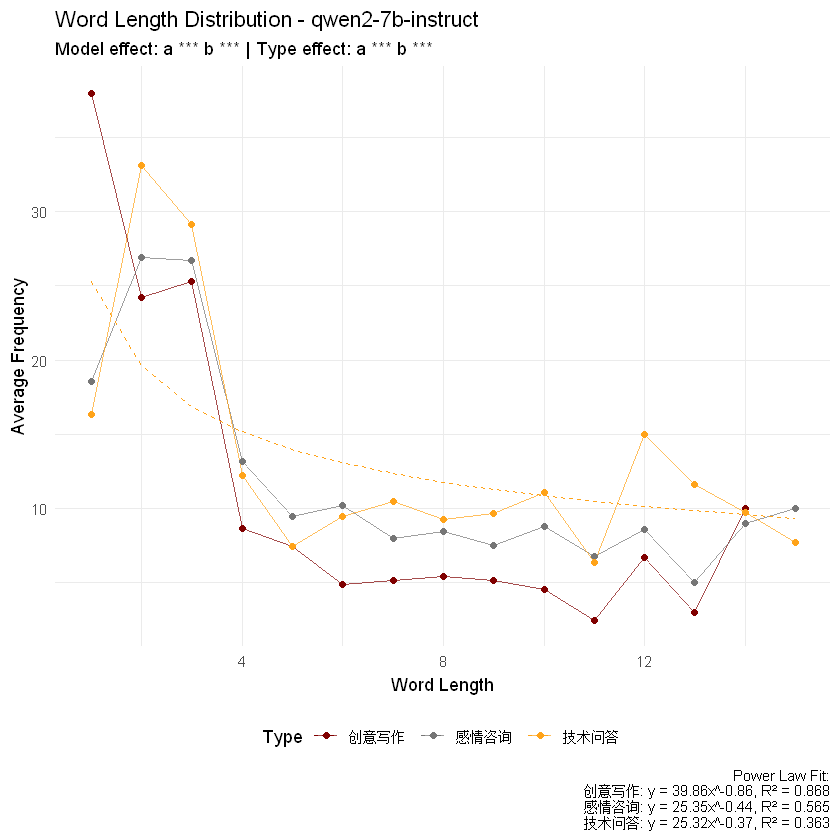

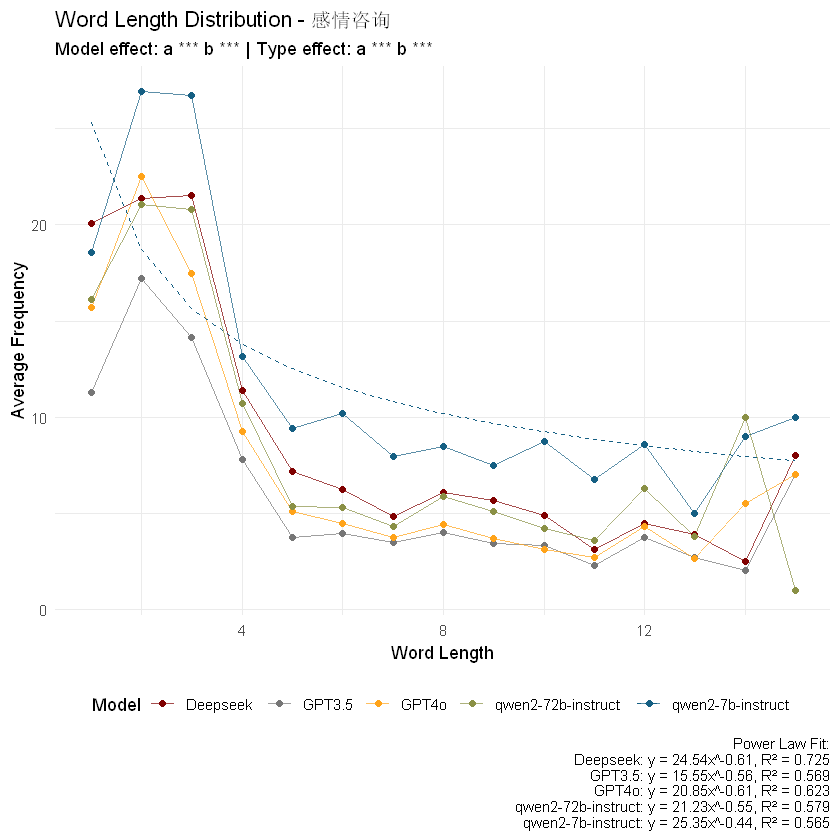

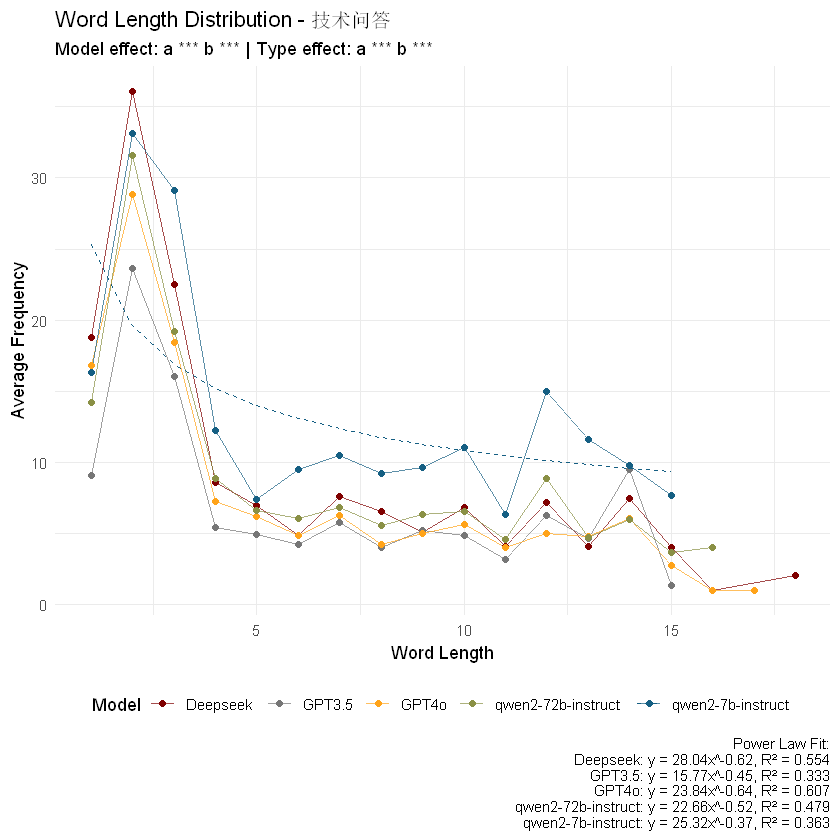

[1] "ANOVA for parameter a:"
Analysis of Variance Table

Response: a
          Df Sum Sq Mean Sq F value    Pr(>F)    
Model      4 275.92  68.981   33.74 0.0002986 ***
Type       2 446.52 223.259  109.20 1.912e-05 ***
Residuals  6  12.27   2.045                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
[1] "ANOVA for parameter b:"
Analysis of Variance Table

Response: b
          Df  Sum Sq  Mean Sq F value    Pr(>F)    
Model      4 0.13232 0.033081  28.176  0.000497 ***
Type       2 0.44572 0.222858 189.816 3.766e-06 ***
Residuals  6 0.00704 0.001174                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


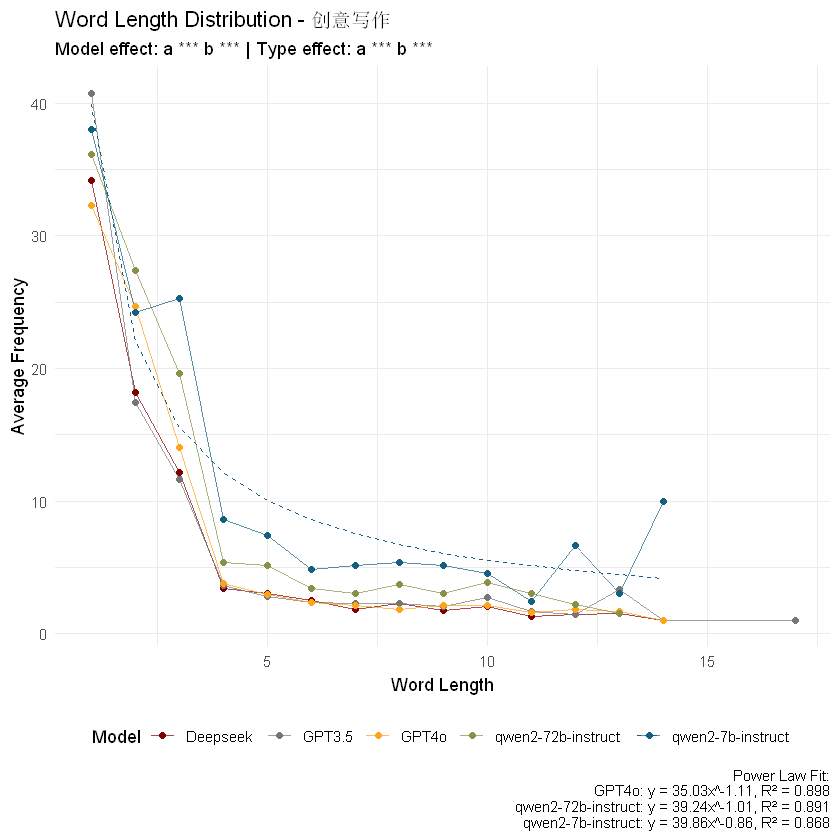

In [17]:
# 定义幂律模型函数
power_law <- function(x, a, b) {
  a * x^b
}

calculate_pseudo_r_squared <- function(model, data) {
  observed <- data$AvgFrequency
  predicted <- predict(model)
  sse <- sum((observed - predicted)^2)
  sst <- sum((observed - mean(observed))^2)
  return(1 - sse/sst)
}
# 修改数据拟合和收集部分
all_fit_results <- data.frame()

for (model in models) {
  model_data <- avg_freq %>% filter(Model == model)
  types <- unique(model_data$Type)

  for (type in types) {
    type_data <- model_data %>% filter(Type == type)

    fit <- try(
      nls2(AvgFrequency ~ power_law(WordLength, a, b),
        data = type_data,
        start = list(a = 1, b = -1)
      ),
      silent = TRUE
    )

    if (!inherits(fit, "try-error")) {
      params <- coef(fit)
      a <- params["a"]
      b <- params["b"]
      r_squared <- calculate_pseudo_r_squared(fit, type_data)

      # 存储拟合结果，包括R²
      all_fit_results <- rbind(
        all_fit_results,
        data.frame(
          Model = model, Type = type,
          a = a, b = b, R_squared = r_squared
        )
      )
    }
  }
}

# 第二步：进行ANOVA分析
a_model <- lm(a ~ Model + Type, data = all_fit_results)
b_model <- lm(b ~ Model + Type, data = all_fit_results)

a_anova <- anova(a_model)
b_anova <- anova(b_model)

# 辅助函数：获取显著性标记
get_significance <- function(p_value) {
  if (p_value < 0.001) return("***")
  if (p_value < 0.01) return("**")
  if (p_value < 0.05) return("*")
  return("")
}



# 为每个Model创建一个图
for (model in models) {
  model_data <- avg_freq %>% filter(Model == model)
  types <- unique(model_data$Type)
  colors <- paletteer_d("ggsci::default_uchicago", n = length(types))

  p <- ggplot(model_data, aes(x = WordLength, y = AvgFrequency, color = Type, group = Type)) +
    geom_line(alpha = 0.7) +
    geom_point() +
    scale_color_manual(values = colors) +
    labs(title = paste("Word Length Distribution -", model),
         subtitle = paste("Model effect: a", get_significance(a_anova["Model", "Pr(>F)"]),
                          "b", get_significance(b_anova["Model", "Pr(>F)"]),
                          "| Type effect: a", get_significance(a_anova["Type", "Pr(>F)"]),
                          "b", get_significance(b_anova["Type", "Pr(>F)"])),
         x = "Word Length",
         y = "Average Frequency") +
    theme_minimal() +
    theme(legend.position = "bottom")



  fit_summary <- character()
  for (type in types) {
    fit_params <- all_fit_results %>%
      filter(Model == model, Type == type)

    if (nrow(fit_params) > 0) {
      p <- p + geom_line(data = model_data %>% filter(Type == type),
                         aes(y = power_law(WordLength, fit_params$a, fit_params$b)),
                         linetype = "dashed")

      fit_summary <- c(fit_summary,
                       paste0(type, ": y = ", round(fit_params$a, 2),
                              "x^", round(fit_params$b, 2),
                              ", R² = ", round(fit_params$R_squared, 3)))
    }
  }

  p <- p + labs(caption = paste("Power Law Fit:\n", paste(fit_summary, collapse = "\n")))

  print(p)

  temp_file <- tempfile(fileext = ".png")
  ggsave(temp_file, p, width = 12, height = 8)
  #IRdisplay::display_png(file = temp_file)
}


# 为每个Type创建一个图
for (type in unique(all_fit_results$Type)) {
  type_data <- avg_freq %>% filter(Type == type)
  models <- unique(type_data$Model)
  colors <- paletteer_d("ggsci::default_uchicago", n = length(models))

  p <- ggplot(type_data, aes(x = WordLength, y = AvgFrequency, color = Model, group = Model)) +
    geom_line(alpha = 0.7) +
    geom_point() +
    scale_color_manual(values = colors) +
    labs(title = paste("Word Length Distribution -", type),
         subtitle = paste("Model effect: a", get_significance(a_anova["Model", "Pr(>F)"]),
                          "b", get_significance(b_anova["Model", "Pr(>F)"]),
                          "| Type effect: a", get_significance(a_anova["Type", "Pr(>F)"]),
                          "b", get_significance(b_anova["Type", "Pr(>F)"])),
         x = "Word Length",
         y = "Average Frequency") +
    theme_minimal() +
    theme(legend.position = "bottom")



  fit_summary <- character()
  for (model in models) {
    fit_params <- all_fit_results %>%
      filter(Model == model, Type == type)

    if (nrow(fit_params) > 0) {
      p <- p + geom_line(data = model_data %>% filter(Type == type),
                         aes(y = power_law(WordLength, fit_params$a, fit_params$b)),
                         linetype = "dashed")

      fit_summary <- c(fit_summary,
                       paste0(model, ": y = ", round(fit_params$a, 2),
                              "x^", round(fit_params$b, 2),
                              ", R² = ", round(fit_params$R_squared, 3)))
    }
  }

  p <- p + labs(caption = paste("Power Law Fit:\n", paste(fit_summary, collapse = "\n")))



  p <- p + labs(caption = paste("Power Law Fit:\n", paste(fit_summary, collapse = "\n")))

  print(p)

  temp_file <- tempfile(fileext = ".png")
  ggsave(temp_file, p, width = 12, height = 8)
  #IRdisplay::display_png(file = temp_file)
}

# 打印 ANOVA 结果
print("ANOVA for parameter a:")
print(a_anova)
print("ANOVA for parameter b:")
print(b_anova)


$感情咨询
       a.a        b.b 
24.5359470 -0.6070693 

$技术问答
       a.a        b.b 
28.0435724 -0.6237159 



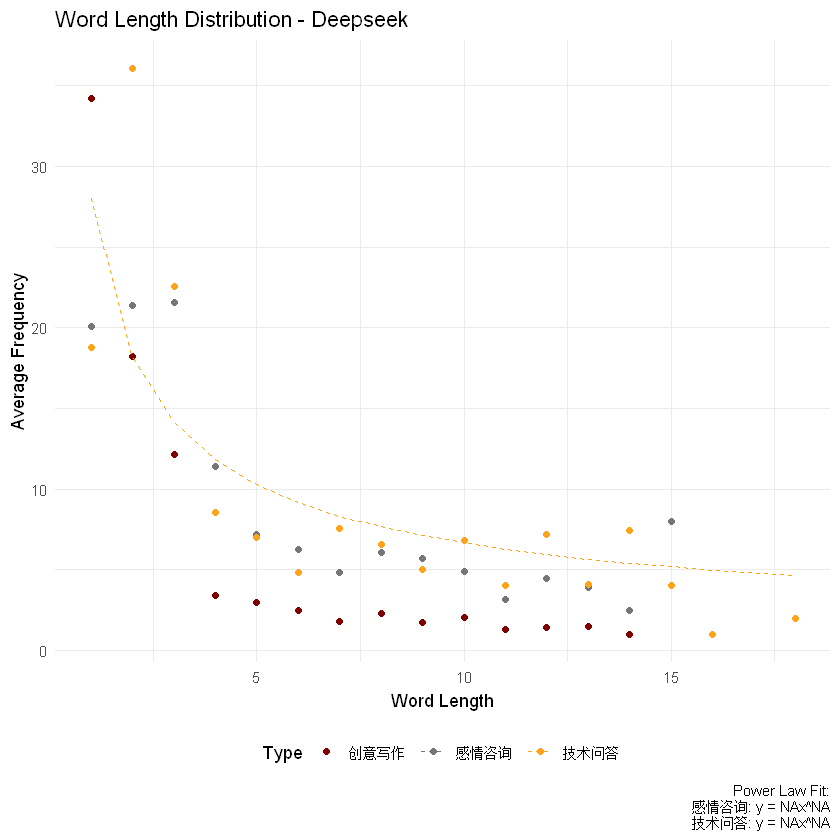

$感情咨询
      a.a       b.b 
15.550309 -0.555099 

$技术问答
       a.a        b.b 
15.7747601 -0.4492335 



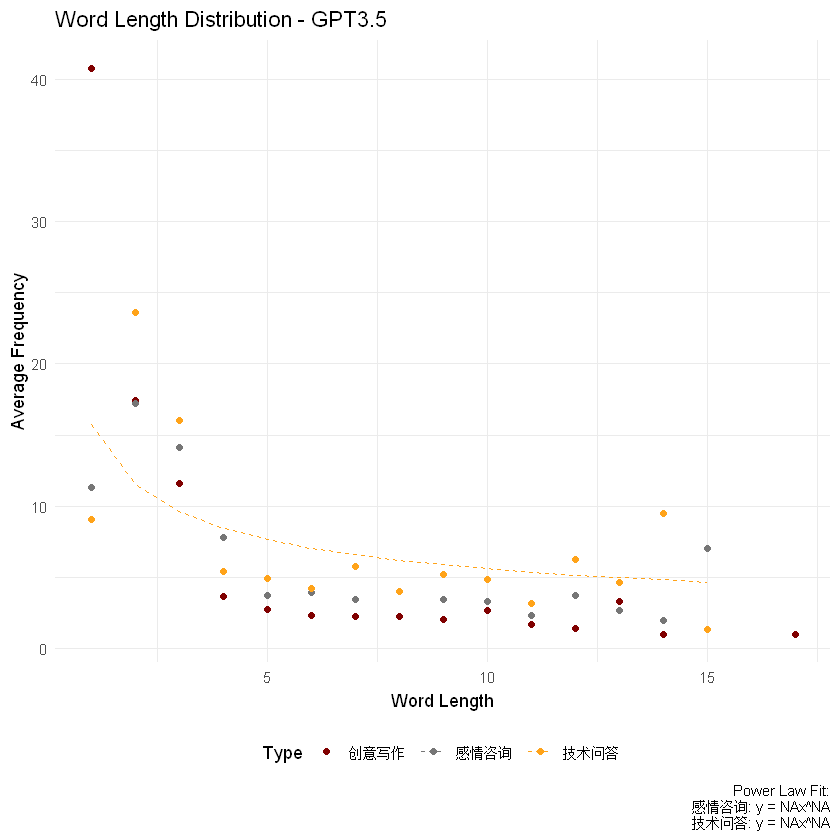

$创意写作
     a.a      b.b 
35.02646 -1.11034 

$感情咨询
       a.a        b.b 
20.8479747 -0.6065119 

$技术问答
      a.a       b.b 
23.839798 -0.637614 



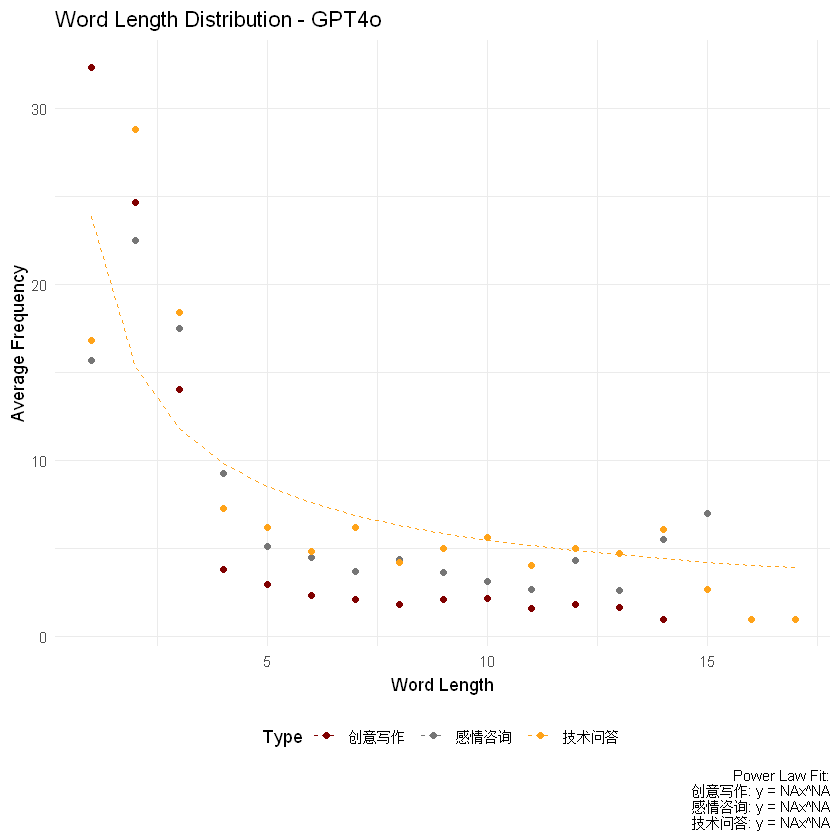

$创意写作
      a.a       b.b 
39.238580 -1.006731 

$感情咨询
       a.a        b.b 
21.2307611 -0.5522009 

$技术问答
      a.a       b.b 
22.662601 -0.520041 



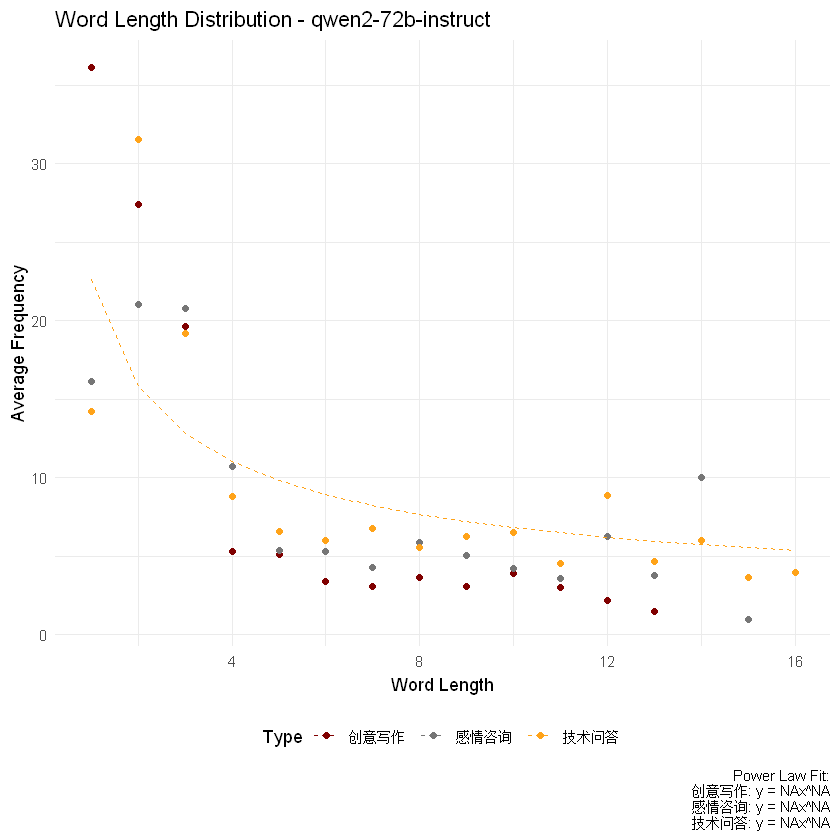

$创意写作
       a.a        b.b 
39.8552152 -0.8569516 

$感情咨询
       a.a        b.b 
25.3548766 -0.4388515 

$技术问答
       a.a        b.b 
25.3173546 -0.3685581 



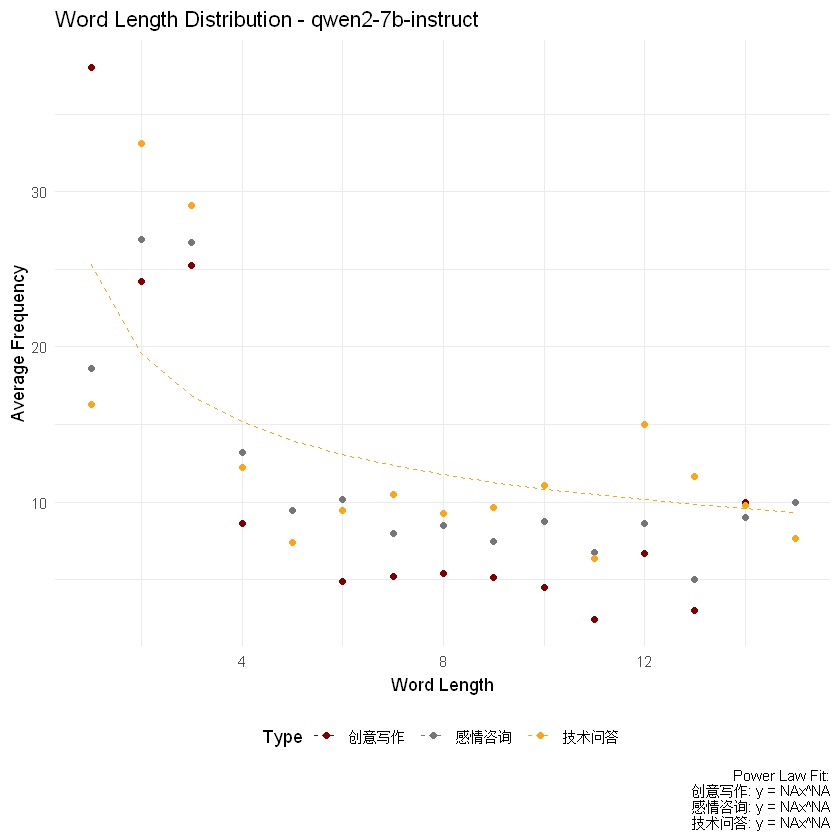

In [6]:
# 定义幂律模型函数
power_law <- function(x, a, b) {
  a * x^b
}

# 为每个Model创建一个图
for (model in models) {
  # 筛选当前Model的数据
  model_data <- avg_freq %>% filter(Model == model)

  # 获取当前Model的唯一Type值
  types <- unique(model_data$Type)

  # 使用paletteer选择配色方案
  colors <- paletteer_d("ggsci::default_uchicago", n = length(types))

  # 创建一个列表来存储每个Type的拟合结果
  fit_results <- list()

  # 创建折线图
  p <- ggplot(model_data, aes(x = WordLength, y = AvgFrequency, color = Type)) +
    geom_point() +
    scale_color_manual(values = colors) +
    labs(title = paste("Word Length Distribution -", model),
         x = "Word Length",
         y = "Average Frequency") +
    theme_minimal() +
    theme(legend.position = "bottom")

  # 为每个Type拟合幂律模型并添加到图中
  for (type in types) {
    type_data <- model_data %>% filter(Type == type)

    # 拟合幂律模型
    fit <- try(nls2(AvgFrequency ~ power_law(WordLength, a, b),
                    data = type_data,
                    start = list(a = 1, b = -1)),
               silent = TRUE)

    if (!inherits(fit, "try-error")) {
      # 提取参数
      params <- coef(fit)
      a <- params["a"]
      b <- params["b"]

      # 添加拟合线到图中
      p <- p + geom_line(data = type_data,
                         aes(y = power_law(WordLength, a, b)),
                         linetype = "dashed")

      # 存储拟合结果
      fit_results[[type]] <- c(a = a, b = b)
    }
  }

  # 添加拟合结果到图表说明
  fit_summary <- paste(sapply(names(fit_results), function(type) {
    paste0(type, ": y = ", round(fit_results[[type]]["a"], 2),
           "x^", round(fit_results[[type]]["b"], 2))
  }), collapse = "\n")

  p <- p + labs(caption = paste("Power Law Fit:\n", fit_summary))

  # 显示图形
  print(p)

  # 保存图片到临时文件并在Jupyter中显示
  temp_file <- tempfile(fileext = ".png")
  ggsave(temp_file, p, width = 12, height = 8)
  #IRdisplay::display_png(file = temp_file)

  # 打印拟合结果
  print(fit_results)
}
